# Problem Statement
## About Company
Dream Housing Finance company deals in all home loans. They have presence across all urban, semi urban and rural areas. Customer first apply for home loan after that company validates the customer eligibility for loan.

## Problem
Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have given a problem to identify the customers segments, those are eligible for loan amount so that they can specifically target these customers. Here they have provided a partial data set.

### Data
#### Variable: Description
* Loan_ID: Unique Loan ID
* Gender: Male/ Female
* Married: Applicant married (Y/N)
* Dependents: Number of dependents
* Education: Applicant Education (Graduate/ Under Graduate)
* Self_Employed: Self employed (Y/N)
* ApplicantIncome: Applicant income
* CoapplicantIncome: Coapplicant income
* LoanAmount: Loan amount in thousands
* Loan_Amount_Term: Term of loan in months
* Credit_History: credit history meets guidelines
* Property_Area: Urban/ Semi Urban/ Rural
* Loan_Status: Loan approved (Y/N)


## Note: 
1. Evaluation Metric is accuracy i.e. percentage of loan approval you correctly predict.
2. You are expected to upload the solution in the format of "sample_submission.csv"

In [525]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import Imputer
from sklearn import model_selection
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, \
    AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, mean_squared_error
import xgboost as xgb

%matplotlib inline

In [526]:
df_test = pd.read_csv("../data/loan_prediction/test_Y3wMUE5_7gLdaTN.csv")
df_train = pd.read_csv("../data/loan_prediction/train_u6lujuX_CVtuZ9i.csv")

In [527]:
df_train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


#### Descriptive analytics

In [528]:
df_train.transpose()

,0,1,2,3,4,5,6,7,8,9,...,604,605,606,607,608,609,610,611,612,613
Loan_ID,LP001002,LP001003,LP001005,LP001006,LP001008,LP001011,LP001013,LP001014,LP001018,LP001020,...,LP002959,LP002960,LP002961,LP002964,LP002974,LP002978,LP002979,LP002983,LP002984,LP002990
Gender,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,...,Female,Male,Male,Male,Male,Female,Male,Male,Male,Female
Married,No,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,...,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No
Dependents,0,1,0,0,0,2,0,3+,2,1,...,1,0,1,2,0,0,3+,1,2,0
Education,Graduate,Graduate,Graduate,Not Graduate,Graduate,Graduate,Not Graduate,Graduate,Graduate,Graduate,...,Graduate,Not Graduate,Graduate,Not Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate
Self_Employed,No,No,Yes,No,No,Yes,No,No,No,No,...,No,No,No,No,No,No,No,No,No,Yes
ApplicantIncome,5849,4583,3000,2583,6000,5417,2333,3036,4006,12841,...,12000,2400,3400,3987,3232,2900,4106,8072,7583,4583
CoapplicantIncome,0,1508,0,2358,0,4196,1516,2504,1526,10968,...,0,3800,2500,1411,1950,0,0,240,0,0
LoanAmount,NaN,128,66,120,141,267,95,158,168,349,...,496,NaN,173,157,108,71,40,253,187,133
Loan_Amount_Term,360,360,360,360,360,360,360,360,360,360,...,360,180,360,360,360,360,180,360,360,360


In [529]:
df_train_binary = df_train

# Loan status = 1 if Yes, 0 if No
df_train_binary['Loan_Status'] = df_train_binary['Loan_Status'].apply(lambda x: 1 if x=='Y' else 0)
# Applicant gender = 1 if Female, 0 if Male
df_train_binary['Gender'] = df_train_binary['Gender'].apply(lambda x: 1 if x=='Female' else 0)
# Self-employed = 1 if Yes, 0 if No
df_train_binary['Self_Employed'] = df_train_binary['Self_Employed'].apply(lambda x: 1 if x=="Yes" else 0)
# Married = 1 if Yes, 0 if No
df_train_binary['Married'] = df_train_binary['Married'].apply(lambda x: 1 if x=="Yes" else 0)

In [530]:

# Property area, education, and dependents
property_area_vectorizer = CountVectorizer()
education_vectorizer = CountVectorizer()
dependents_vectorizer = CountVectorizer()

prop_area_vec = property_area_vectorizer.fit_transform(df_train_binary.Property_Area)
education_vec = education_vectorizer.fit_transform(df_train_binary.Education)
# This cannot have NaN, so we just use None as a string
df_train_binary['Dependents'] = df_train_binary['Dependents'].fillna(value="None")
dep_vec = dependents_vectorizer.fit_transform(df_train_binary.Dependents)

print(property_area_vectorizer.get_feature_names())
print(education_vectorizer.get_feature_names())
print(dependents_vectorizer.get_feature_names())

df_train_binary['Education'] = df_train_binary['Education'].apply(lambda row: int(''.join(map(str, education_vectorizer.transform([row]).toarray()[0])), 2))
df_train_binary['Property_Area'] = df_train_binary['Property_Area'].apply(lambda row: int(''.join(map(str, property_area_vectorizer.transform([row]).toarray()[0])), 2))
df_train_binary['Dependents'] = df_train_binary['Dependents'].apply(lambda row: int(''.join(map(str, dependents_vectorizer.transform([row]).toarray()[0])), 2))

['rural', 'semiurban', 'urban']
['graduate', 'not']
['none']


`Loan ammount` is of course related to the `applicant income`

`Loan status` seems most correlated with `credit history`

We can visualize this (lower triangularizing to ignore the diagonal and above as it is redundant)

In [531]:
df_train_binary.corr()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Gender,1.000000,-0.367389,0.007208,-0.045364,0.000525,-0.058809,-0.082912,-0.109520,0.074539,-0.013472,-0.047446,-0.017987
Married,-0.367389,1.000000,-0.038068,0.017671,0.008491,0.050194,0.080496,0.148367,-0.104608,0.001259,-0.000344,0.084281
Dependents,0.007208,-0.038068,1.000000,0.018553,-0.000101,-0.005596,-0.029503,-0.031588,0.032579,-0.079589,-0.060076,-0.029798
Education,-0.045364,0.017671,0.018553,1.000000,-0.010383,-0.140760,-0.062290,-0.171133,-0.078784,-0.081822,0.072376,-0.085884
Self_Employed,0.000525,0.008491,-0.000101,-0.010383,1.000000,0.127180,-0.016100,0.117421,-0.034361,-0.002362,0.028686,-0.003700
ApplicantIncome,-0.058809,0.050194,-0.005596,-0.140760,0.127180,1.000000,-0.116605,0.570909,-0.045306,-0.014715,0.012264,-0.004710
CoapplicantIncome,-0.082912,0.080496,-0.029503,-0.062290,-0.016100,-0.116605,1.000000,0.188619,-0.059878,-0.002056,-0.004897,-0.059187
LoanAmount,-0.109520,0.148367,-0.031588,-0.171133,0.117421,0.570909,0.188619,1.000000,0.039447,-0.008433,0.046831,-0.037318
Loan_Amount_Term,0.074539,-0.104608,0.032579,-0.078784,-0.034361,-0.045306,-0.059878,0.039447,1.000000,0.001470,0.065019,-0.021268
Credit_History,-0.013472,0.001259,-0.079589,-0.081822,-0.002362,-0.014715,-0.002056,-0.008433,0.001470,1.000000,-0.006706,0.561678


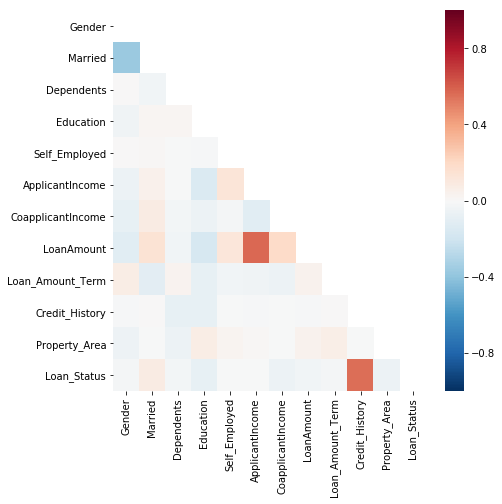

In [574]:
df_UT = df_train_binary.corr().where(np.tril(np.ones(df_train_binary.corr().shape), k=-1).astype(np.bool))
plt.figure(figsize=(7,7))
sns.heatmap(df_UT, vmin=-1, vmax=1, cmap=plt.cm.RdBu_r)
plt.savefig('../figures/loan_prediction_correlations.png', bbox_inches='tight')

In [533]:
df_train_binary.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,0,0,0,2,0,5849,0.0,NaN,360.0,1.0,1,1
1,LP001003,0,1,0,2,0,4583,1508.0,128.0,360.0,1.0,4,0
2,LP001005,0,1,0,2,1,3000,0.0,66.0,360.0,1.0,1,1
3,LP001006,0,1,0,3,0,2583,2358.0,120.0,360.0,1.0,1,1
4,LP001008,0,0,0,2,0,6000,0.0,141.0,360.0,1.0,1,1


#### Select numeric values and pre-process by filling in the mean where NaN

In [547]:
array = df_train_binary[['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status']].values
X = array[:,:-1]
# Create our imputer to replace missing values with the mean e.g.
imp = Imputer(missing_values='NaN', strategy='mean', axis=0)
imp = imp.fit(X)
# Impute our data, then train
# X_train_imp = imp.transform(X)
X_train_imp = pd.DataFrame(imp.fit_transform(X), columns=['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'])
Y = array[:,-1]

### Bagging algorithms

#### Bagged decision trees

In [548]:
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
cart = DecisionTreeClassifier()
num_trees = 100
model = BaggingClassifier(base_estimator=cart, n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, X_train_imp, Y, cv=kfold)
print(results.mean())

0.7673717609730302


#### Random forest

In [549]:
seed = 7
num_trees = 100
max_features = 3
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features)
results = model_selection.cross_val_score(model, X_train_imp, Y, cv=kfold)
print(results.mean())

0.7835536753040719


#### Extra trees

In [550]:
seed = 7
num_trees = 100
max_features = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)
results = model_selection.cross_val_score(model, X_train_imp, Y, cv=kfold)
print(results.mean())

0.757429931253305


### Boosting

#### AdaBoost

In [551]:
seed = 7
num_trees = 30
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = AdaBoostClassifier(n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, X_train_imp, Y, cv=kfold)
print(results.mean())

0.7965362242199895


#### Stochastic gradient boost

In [552]:
seed = 7
num_trees = 100
kfold = model_selection.KFold(n_splits=10, random_state=seed)
model = GradientBoostingClassifier(n_estimators=num_trees, random_state=seed)
results = model_selection.cross_val_score(model, X_train_imp, Y, cv=kfold)
print(results.mean())

0.7737704918032786


#### Voting ensemble

In [553]:
seed = 7
kfold = model_selection.KFold(n_splits=10, random_state=seed)
# create the sub models
estimators = []
model1 = LogisticRegression()
estimators.append(('logistic', model1))
model2 = DecisionTreeClassifier()
estimators.append(('cart', model2))
model3 = SVC()
estimators.append(('svm', model3))
# create the ensemble model
ensemble = VotingClassifier(estimators)
results = model_selection.cross_val_score(ensemble, X_train_imp, Y, cv=kfold)
print(results.mean())

0.803146483342147


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

### Gradient boosting regularization

Regularization via shrinkage (`learning_rate < 1.0`) improves performance considerably. 
In combination with shrinkage, stochastic gradient boosting (`subsample < 1.0`) can produce more accurate models by reducing the variance via bagging.

In [554]:
s70 = int(len(X)*.7)
X_train, X_test = X_train_imp[:s70], X_train_imp[s70:]
y_train, y_test = Y[:s70], Y[s70:]

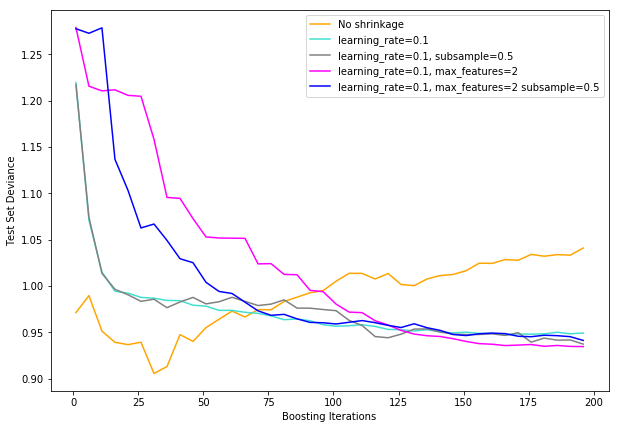

In [575]:
original_params = {'n_estimators': 200, 'max_leaf_nodes': 2, 'max_depth': None, 'random_state': 2,
                   'min_samples_split': 5}

plt.figure(figsize=(10,7))

for label, color, setting in [('No shrinkage', 'orange',
                               {'learning_rate': 1.0, 'subsample': 1.0}),
                              ('learning_rate=0.1', 'turquoise',
                               {'learning_rate': 0.1, 'subsample': 1.0}),
                              ('learning_rate=0.1, subsample=0.5', 'gray',
                               {'learning_rate': 0.1, 'subsample': 0.5}),
                              ('learning_rate=0.1, max_features=2', 'magenta',
                               {'learning_rate': 0.1, 'max_features': 2}),
                              ('learning_rate=0.1, max_features=2 subsample=0.5', 'blue',
                               {'learning_rate': 0.1, 'max_features': 2, 'subsample': 0.5})
                             ]:
    params = dict(original_params)
    params.update(setting)

    clf = GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    # compute test set deviance
    test_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = clf.loss_(y_test, y_pred)

    plt.plot((np.arange(test_deviance.shape[0]) + 1)[::5], test_deviance[::5],
            '-', color=color, label=label)

plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Test Set Deviance')
plt.savefig('../figures/loan_prediction_shrinkage.png', bbox_inches='tight')
plt.show()

In [556]:
seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_train_imp, Y, test_size=test_size, random_state=seed)


In [584]:
# Fit the model, no training data
model = xgb.XGBClassifier(objective='binary:logistic', 
                          learning_rate = 0.1, 
                          max_depth = 2,  
                          n_estimators = 200, 
                          subsample=0.1, reg_lambda=10
                         )
model.fit(X_train, y_train)
print(model)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

rmse = np.sqrt(mean_squared_error(y_test, predictions))
print("RMSE: %f" % (rmse))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=10, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.1)
Accuracy: 80.79%
RMSE: 0.438313


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [592]:
params = {'objective': 'binary:logistic','learning_rate': 0.1, 'lambda': 10,
                'max_depth': 2, 'n_esimators':200, 'subsample':0.1}

data_dmatrix = xgb.DMatrix(data=X_train_imp,label=Y)
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

[16:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 6 extra nodes, 0 pruned nodes, max_depth=2
[16:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:06:02] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[

In [593]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,0.494158,0.000294,0.494567,0.000510
1,0.487053,0.000795,0.487715,0.002140
2,0.482957,0.000881,0.483916,0.002600
3,0.478161,0.001533,0.479523,0.003261
4,0.471865,0.001592,0.472956,0.004095


In [594]:
print((cv_results["test-rmse-mean"]).tail(1))

49    0.408435
Name: test-rmse-mean, dtype: float64


In [595]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=100, )

[16:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 2 extra nodes, 0 pruned nodes, max_depth=1
[16:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[16:06:05] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 4 extra nodes, 0 pruned nodes, max_depth=2
[

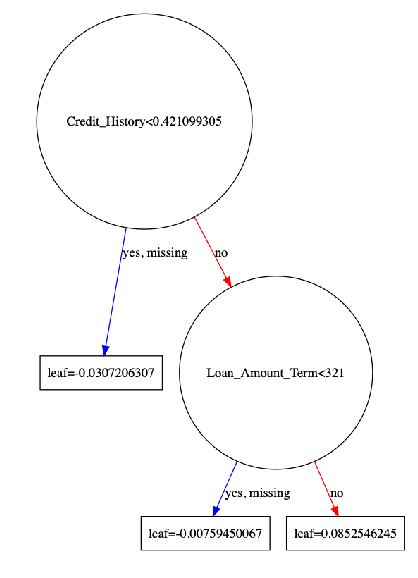

In [600]:
xgb.plot_tree(xg_reg,num_trees=5)
plt.rcParams['figure.figsize'] = [50, 10]
plt.savefig('../figures/loan_prediction_tree.png', bbox_inches='tight')
plt.show()

<Figure size 1080x432 with 0 Axes>

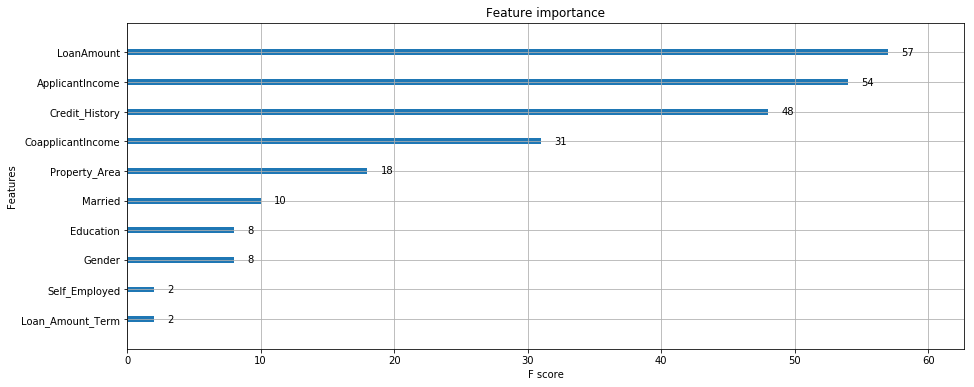

In [598]:
plt.figure(figsize=(15,6))
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [15, 6]
plt.savefig('../figures/loan_prediction_feature_importances.png')
plt.show()

In [609]:
df_test_binary = df_test

# Applicant gender = 1 if Female, 0 if Male
df_test_binary['Gender'] = df_test_binary['Gender'].apply(lambda x: 1 if x=='Female' else 0)
# Self-employed = 1 if Yes, 0 if No
df_test_binary['Self_Employed'] = df_test_binary['Self_Employed'].apply(lambda x: 1 if x=="Yes" else 0)
# Married = 1 if Yes, 0 if No
df_test_binary['Married'] = df_test_binary['Married'].apply(lambda x: 1 if x=="Yes" else 0)

prop_area_vec = property_area_vectorizer.fit_transform(df_test_binary.Property_Area)
education_vec = education_vectorizer.fit_transform(df_test_binary.Education)
# This cannot have NaN, so we just use None as a string
df_test_binary['Dependents'] = df_test_binary['Dependents'].fillna(value="None")
dep_vec = dependents_vectorizer.fit_transform(df_test_binary.Dependents)

print(property_area_vectorizer.get_feature_names())
print(education_vectorizer.get_feature_names())
print(dependents_vectorizer.get_feature_names())

df_test_binary['Education'] = df_test_binary['Education'].apply(lambda row: int(''.join(map(str, education_vectorizer.transform([row]).toarray()[0])), 2))
df_test_binary['Property_Area'] = df_test_binary['Property_Area'].apply(lambda row: int(''.join(map(str, property_area_vectorizer.transform([row]).toarray()[0])), 2))
df_test_binary['Dependents'] = df_test_binary['Dependents'].apply(lambda row: int(''.join(map(str, dependents_vectorizer.transform([row]).toarray()[0])), 2))

X_pred = df_test_binary[['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area']].values
X_pred_imp = pd.DataFrame(imp.fit_transform(X_pred), columns=['Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'])

X_pred_imp.head()

['rural', 'semiurban', 'urban']
['graduate', 'not']
['none']


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,0.0,1.0,0.0,2.0,0.0,5720.0,0.0,110.0,360.0,1.000000,1.0
1,0.0,1.0,0.0,2.0,0.0,3076.0,1500.0,126.0,360.0,1.000000,1.0
2,0.0,1.0,0.0,2.0,0.0,5000.0,1800.0,208.0,360.0,1.000000,1.0
3,0.0,1.0,0.0,2.0,0.0,2340.0,2546.0,100.0,360.0,0.825444,1.0
4,0.0,0.0,0.0,3.0,0.0,3276.0,0.0,78.0,360.0,1.000000,1.0


In [614]:
pred_dmatrix = xgb.DMatrix(data=X_pred_imp)
X_pred_vals = xg_reg.predict(pred_dmatrix)

In [616]:
df_test['Loan_Status'] = X_pred_vals

In [619]:
df_test[['Loan_ID','Loan_Status']].to_csv("../loan_prediction/solution.csv", index=False)